# **Dataset Preparation**

Text(0.5, 1.0, 'Dataset')

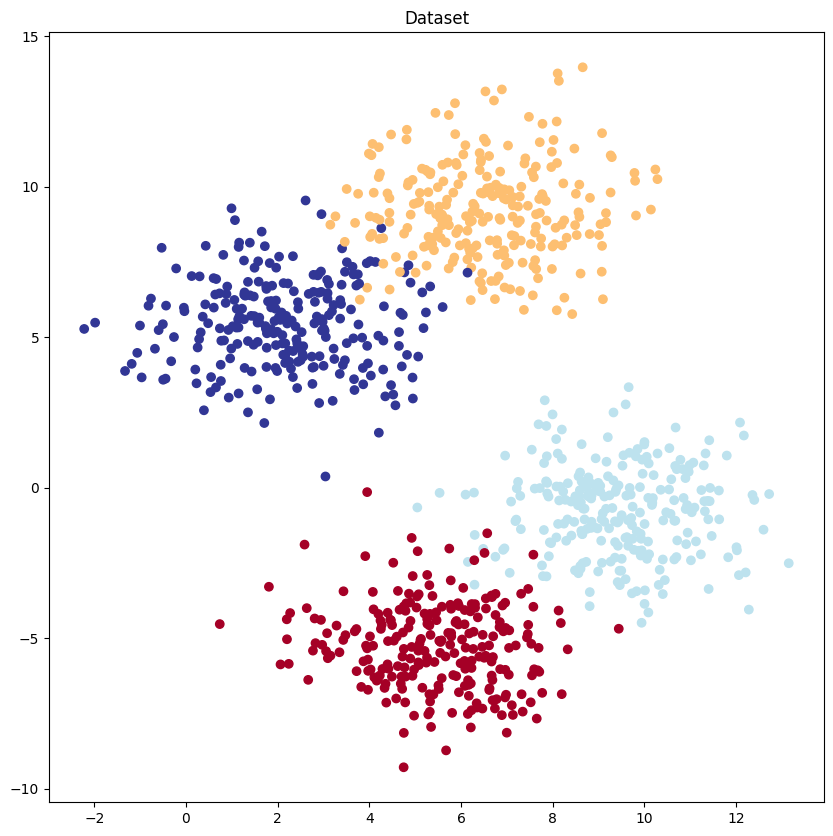

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 13

X, y = make_blobs(n_samples=1000,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,
                  random_state=RANDOM_SEED,
                  cluster_std=1.5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Dataset")

In [2]:
X[:5], y[:5]

(array([[ 6.24986957,  9.1763573 ],
        [ 7.56744857,  6.39035747],
        [ 7.5495236 , -6.2354515 ],
        [ 4.76930189, -5.97123272],
        [ 4.97677464, -7.57561098]]),
 array([1, 1, 0, 0, 0]))

#**Model Creation**

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

class MultiClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=20)
    self.linear2 = nn.Linear(in_features=20, out_features=20)
    self.linear3 = nn.Linear(in_features=20, out_features=4)
    self.relu = nn.ReLU();
  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model = MultiClassificationModel().to(device)
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-0.5773, -0.0292],
                      [ 0.4392, -0.6857],
                      [-0.6855,  0.1465],
                      [-0.3793,  0.5138],
                      [ 0.6871, -0.4278],
                      [-0.5897, -0.1056],
                      [ 0.5867, -0.0284],
                      [ 0.0492, -0.3260],
                      [-0.3493, -0.2277],
                      [ 0.4761, -0.5248],
                      [ 0.6638, -0.0714],
                      [-0.1371,  0.4529],
                      [ 0.6777, -0.2435],
                      [-0.1307,  0.3219],
                      [-0.0698, -0.3771],
                      [-0.6490, -0.3618],
                      [ 0.1523,  0.4629],
                      [ 0.6799, -0.3237],
                      [-0.1277, -0.2825],
                      [ 0.3301, -0.4829]], device='cuda:0')),
             ('linear1.bias',
              tensor([ 0.6620, -0.6302,  0.3990, -0.1255,  0.3736,  0.4630,  0

In [5]:
X_train, X_test = torch.from_numpy(X_train).to(device).type(torch.float), torch.from_numpy(X_test).to(device).type(torch.float)
y_train, y_test = torch.from_numpy(y_train).to(device).type(torch.long), torch.from_numpy(y_test).to(device).type(torch.long)
X_train.shape, X_train.dtype, y_train.shape, y_train.dtype

(torch.Size([800, 2]), torch.float32, torch.Size([800]), torch.int64)

In [6]:
Loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.01)

#**Model Before Training**

In [7]:
with torch.inference_mode():
  preds_logits = model(X_train)
  preds_probs = torch.softmax(preds_logits, dim=1)
  preds = torch.argmax(preds_probs, dim=1)
preds_logits[:5], preds_probs[:5], preds.dtype, y_train.dtype

(tensor([[ 0.8789,  0.3985, -0.0676,  0.2793],
         [-0.4467,  1.5029, -0.2885, -0.0221],
         [ 0.6447,  0.1243, -0.1221,  0.1533],
         [ 0.6814, -0.1199, -0.4076,  0.0689],
         [-0.4833,  1.6102, -0.2684, -0.0072]], device='cuda:0'),
 tensor([[0.3913, 0.2420, 0.1519, 0.2148],
         [0.0932, 0.6550, 0.1092, 0.1425],
         [0.3745, 0.2225, 0.1739, 0.2291],
         [0.4297, 0.1928, 0.1446, 0.2329],
         [0.0836, 0.6782, 0.1036, 0.1346]], device='cuda:0'),
 torch.int64,
 torch.int64)

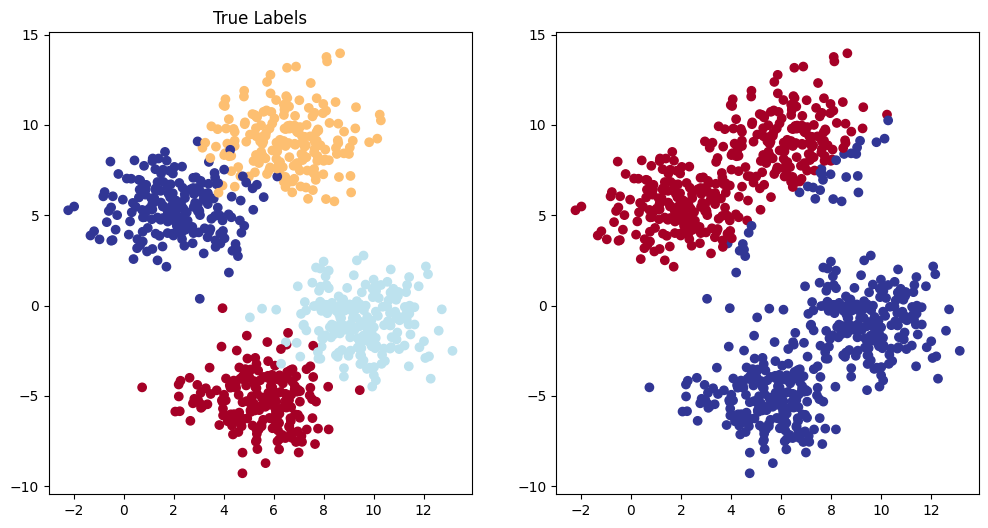

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), cmap=plt.cm.RdYlBu)
plt.title("True Labels")
plt.subplot(1,2,2)
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=preds.cpu(), cmap=plt.cm.RdYlBu)

#**Model Training**

In [9]:
def accuracy(y_pred, y):
  return torch.sum(torch.eq(y_pred, y)).item() / len(y)

In [10]:
accuracy(preds, y_train)

0.03

In [11]:
Train_Loss = []
Test_Loss = []
epochs_count = []

In [12]:
epochs = 801

for epoch in range(epochs):
  model.train()
  preds = model(X_train)
  loss = Loss_fn(preds, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_preds = model(X_test)
    test_loss = Loss_fn(test_preds, y_test)

  Train_Loss.append(loss.item())
  Test_Loss.append(test_loss.item())
  epochs_count.append(epoch)

  if epoch % 10 == 0:
    print(f"epoch : { epoch } || train_loss : {loss.item()} || test_loss : {test_loss} accuracy : {accuracy(y_train, preds.softmax(dim=1).argmax(dim=1))}")



epoch : 0 || train_loss : 1.8465937376022339 || test_loss : 1.6792558431625366 accuracy : 0.03
epoch : 10 || train_loss : 1.211671233177185 || test_loss : 1.2072458267211914 accuracy : 0.26875
epoch : 20 || train_loss : 1.0521798133850098 || test_loss : 1.0449045896530151 accuracy : 0.505
epoch : 30 || train_loss : 0.9468858242034912 || test_loss : 0.9329987168312073 accuracy : 0.76875
epoch : 40 || train_loss : 0.8652486205101013 || test_loss : 0.8453944325447083 accuracy : 0.80125
epoch : 50 || train_loss : 0.7971755266189575 || test_loss : 0.772834837436676 accuracy : 0.7975
epoch : 60 || train_loss : 0.7399611473083496 || test_loss : 0.7128897905349731 accuracy : 0.79375
epoch : 70 || train_loss : 0.691154420375824 || test_loss : 0.6627403497695923 accuracy : 0.80625
epoch : 80 || train_loss : 0.6482732892036438 || test_loss : 0.6196407079696655 accuracy : 0.835
epoch : 90 || train_loss : 0.6104175448417664 || test_loss : 0.582537055015564 accuracy : 0.84875
epoch : 100 || train_lo

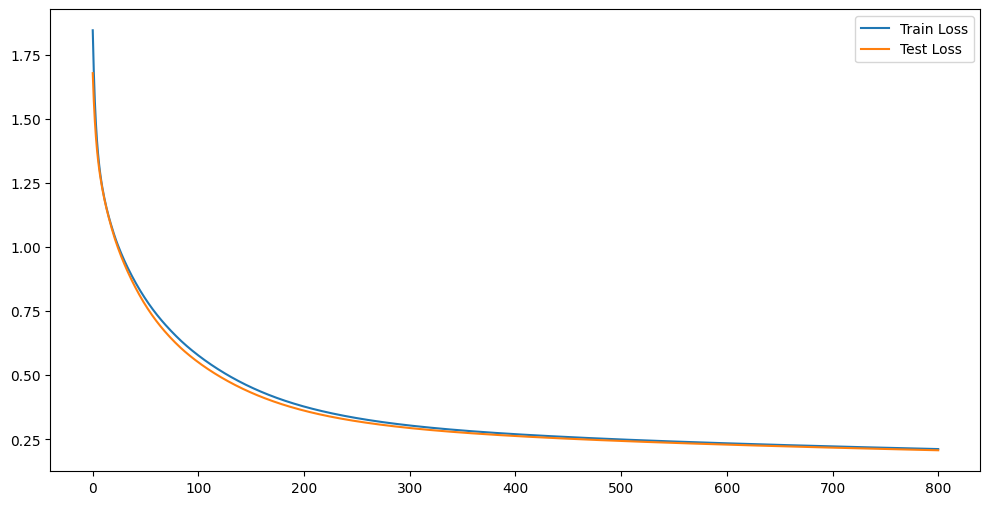

In [13]:
plt.figure(figsize=(12,6))
plt.plot(epochs_count, Train_Loss, label="Train Loss")
plt.plot(epochs_count, Test_Loss, label="Test Loss")
plt.legend()

#**Model After Training**

In [14]:
model.eval()
with torch.inference_mode():
  preds_logits = model(torch.from_numpy(X).to(device).type(torch.float))
  preds_probs = torch.softmax(preds_logits, dim=1)
  preds = torch.argmax(preds_probs, dim=1)
eq = torch.eq(preds, torch.from_numpy(y).to(device))

Text(0.5, 1.0, 'Correct Predictions')

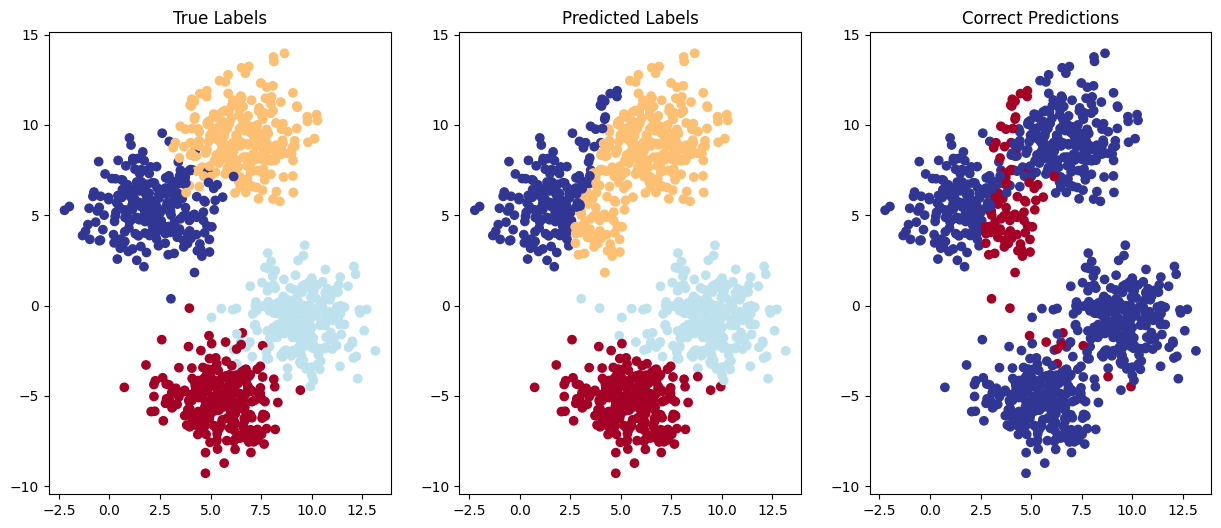

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("True Labels")
plt.subplot(1,3,2)
plt.scatter(X[:, 0], X[:, 1], c=preds.cpu(), cmap=plt.cm.RdYlBu)
plt.title("Predicted Labels")
plt.subplot(1,3,3)
plt.scatter(X[:, 0], X[:, 1], c=eq.cpu(), cmap=plt.cm.RdYlBu)
plt.title("Correct Predictions")

#**Plot Decision Boundry**

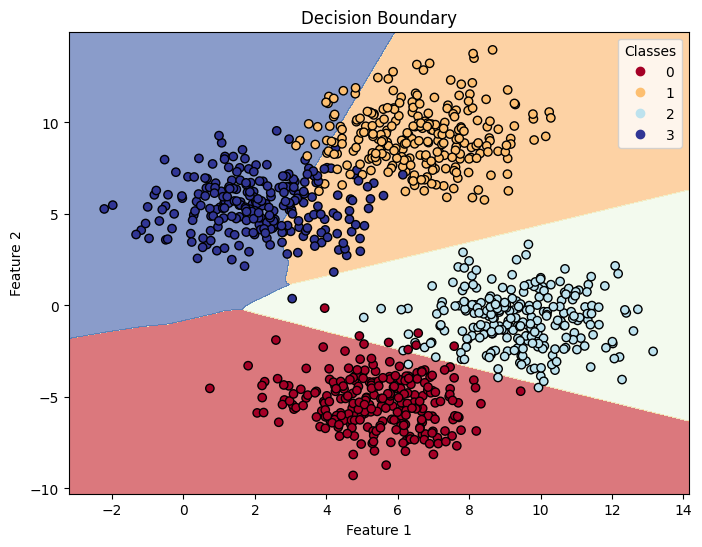

In [16]:
import numpy as np
# from matplotlib.colors import ListedColormap
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float, device=device)
model.eval()
with torch.inference_mode():
    preds = model(grid_tensor)
    preds = preds.argmax(dim=1).cpu().numpy()

preds = preds.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, preds, alpha=0.6, cmap=plt.cm.RdYlBu)


scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary")
plt.show()

#**Model Saving**

In [17]:
import os
torch.save(model.state_dict(), "model.pth")